In [1]:
#https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

In [3]:
%load_ext autoreload
%autoreload 2


import sys,os
import numpy as np
import readline
#from rpy2.rinterface import R_VERSION_BUILD
#print(R_VERSION_BUILD)
#import rpy2.robjects as robjects
#import rpy2.robjects.numpy2ri
import math
import datetime
import pandas as pd
#import seaborn as sns

from scipy.fftpack import fft, ifft


#Import compressivesesning libs
sys.path.insert(0,"..")

from pyCompressSensing.SignalFrame import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from scipy.stats import geninvgauss,gamma

## Impport r package if necessary:

In [4]:
#Set proxy if needed
os.environ["http_proxy"] = "http://proxy-internet-aws-eu.subsidia.org:3128"
os.environ["https_proxy"] = "http://proxy-internet-aws-eu.subsidia.org:3128"
        

In [5]:
#https://rpy2.readthedocs.io/en/version_2.8.x/introduction.html#r-packages

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# Install dependencies
packnames = ['GeneralizedHyperbolic','MASS']
names_to_install = [x for x in packnames if (not rpackages.isinstalled(x))]

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.

if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
    
    
#Imports R packages
#see https://cran.r-project.org/web/views/Distributions.html
from rpy2.robjects.packages import importr
r_GIG = importr('GeneralizedHyperbolic') #used for Generalized Gaussian Inverse distribution
r_stats = importr('stats') #used for Normal, gamma distribution
r_MASS = importr('MASS') #used for multivariate Normal distribution

/home/tdenimal/.conda/envs/compressive_sensing/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependency ‘DistributionUtils’


  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/.conda/envs/compressive_sensing/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/DistributionUtils_0.6-0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/.conda/envs/compressive_sensing/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/.conda/envs/compressive_sensing/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 41231 bytes (40 KB)

  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/.conda/envs/compressive_sensing/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeW

## General functions

In [6]:
def sample_gauss(size):
    return np.random.normal(loc=0.0, scale=1.0,size=size)

In [7]:
def psi_inv(x,scale):
    return ifft(x)*scale

def psi_invt(x,scale):
    return fft(x)/scale

## Sample functions

In [8]:
def sample_x(y, tau, _lambda, gamma_r,gamma_i,v,alpha,phi,psi_inv_phit_y):
    N=phi.shape[1]
    M=phi.shape[0]
    
    
    LHS_r = np.array([math.pow((1/alpha) + _lambda*(1/gamma_ind),-1) for gamma_ind in gamma_r])
    LHS_i = np.array([math.pow((1/alpha) + _lambda*(1/gamma_ind),-1) for gamma_ind in gamma_i])
    
    m = tau*psi_inv_phit_y+v
    
    mu_tilde_r = np.real(LHS_r*np.real(m))
    mu_tilde_i = np.real(LHS_i*np.imag(m))
    
    gauss_v3 = sample_gauss(N)
    gauss_v4 = sample_gauss(N)
    
    
    LHS2_r = np.array([math.pow((1/alpha) + _lambda*(1/gamma_ind),-1/2) for gamma_ind in gamma_r])
    LHS2_i = np.array([math.pow((1/alpha) + _lambda*(1/gamma_ind),-1/2) for gamma_ind in gamma_i])
    
    x_r = mu_tilde_r + LHS2_r * gauss_v3
    x_i = mu_tilde_i + LHS2_i * gauss_v4
    
    x = x_r + x_i*1j
    
    return x

In [9]:
def sample_v(x,tau,alpha,phi):
    N=phi.shape[1]
    M=phi.shape[0]
    
    mu = (1/alpha)*x-tau*psi_invt(phi.T@phi@psi_inv(x,math.sqrt(N)),math.sqrt(N))
    
    
    V2_1 = sample_gauss(N) + sample_gauss(N)*1j
    V2_1 = math.sqrt(1/2)*V2_1
    V2_2 = sample_gauss(M) + sample_gauss(M)*1j
    V2_2 = math.sqrt(1/2)*V2_2
    
    sqrt_alpha = math.sqrt(alpha)
    sqrt_1_alpha = math.sqrt(1-alpha)
    
    
    V2 = math.pow(alpha,-1/2)*V2_1-sqrt_alpha*phi.T@phi@V2_1 + (sqrt_1_alpha)*phi.T@V2_2
    
    V1 = psi_invt(V2,math.sqrt(N))
    
    V = mu + V1
    
    #Condition for positive definite condition
    #init tau à 1/std(y)
    
    return V

In [10]:
%%latex
$$ \boxed{\gamma_n \mid x_{n},\lambda \sim GIG(1,\lambda x_{n}^{2},\frac{1}{2})} $$

<IPython.core.display.Latex object>

In [63]:
def sample_gamma(_lambda,x):
    gamma_n = []
    for x_n in x :
        b_chi =  _lambda*math.pow(np.real(x_n),2)
        a_psi = 1
        c_lambda = 1/2
        rv = geninvgauss.rvs(c_lambda, np.sqrt(b_chi*a_psi), loc=0, scale=np.sqrt(a_psi/b_chi), size=1, random_state=None)
        #param = robjects.FloatVector([b_chi,a_psi,c_lambda])
        #Dnas le package les param : c(chi, psi, lambda) = b,a,c
        #gamma_n.append(np.array(r_GIG.rgig(1,param = param))[0])
        gamma_n.append(rv)
    return np.concatenate(gamma_n).ravel()
    #return np.array(gamma_n)

In [52]:
%%latex
$$ \boxed{\lambda \mid x,\gamma \sim \operatorname{Gamma}(N+a_{\lambda},b_{\lambda}+\frac{1}{2}x^{T}\operatorname{diag}\left(\gamma^{-1}\right)x)} $$

<IPython.core.display.Latex object>

In [53]:
def sample_lambda(x,gamma_r,gamma_i,a_lambda = 1e-6,b_lambda = 1e-6):
    N = x.shape[0]
    shape = N+a_lambda
    x_r = np.real(x)
    x_i = np.imag(x)
    
    
    rate = np.real(b_lambda + (1/2)*((x_r.T@np.linalg.inv(np.diag(gamma_r))@x_r) + (x_i.T@np.linalg.inv(np.diag(gamma_i))@x_i)))
    return gamma.rvs(a=shape,scale=1/rate, size=1, random_state=None)


    #return np.array(r_stats.rgamma(1, shape = shape, rate = rate))    

In [54]:
%%latex
$$ \boxed{\tau \mid x,y \sim \operatorname{Gamma}(M+a_{\tau},b_{\tau}+\frac{1}{2}\|y - \phi \psi^{-1}X\|^{2}_{2})} $$

<IPython.core.display.Latex object>

In [55]:
def sample_tau(x,y,phi,a_tau = 1e-6,b_tau = 1e-6):
    M = y.shape[0]
    N = x.shape[0]
    #M au lieu de M/2 car partie relle et partie complexe
    shape = (M)+a_tau
    rate = b_tau + (1/2)*(math.pow(np.linalg.norm(y - phi@psi_inv(x,math.sqrt(N)),2),2))
    return gamma.rvs(a=shape,scale=1/rate, size=1, random_state=None)
    #return np.array(r_stats.rgamma(1, shape = shape, rate = rate)) 

## Collapsed Gibbs sampler ( )

In [67]:
def gibbs(y, iters, init, hypers,phi):
    #Init parameters
    _lambda = init["lambda"]
    tau = init["tau"]
    gamma_r = init["gamma"]
    gamma_i = init["gamma"]
    v = init["v"]
    
    
    #Optimisation
    M=phi.shape[0]
    N=phi.shape[1]
    psi_inv_phit_y = psi_inv(phi.T@y,math.sqrt(N))
    print(psi_inv_phit_y.shape)
    
    trace = np.zeros((iters, 3), dtype=object) ## trace to store values of x,tau,lambda,gamma
    
    for it in range(iters):
        alpha = 0.1*tau
        
        x = sample_x(y, tau, _lambda, gamma_r,gamma_i,v,alpha,phi,psi_inv_phit_y)
        x_r = np.real(x)
        x_i = np.imag(x)
        
        
        
        
        
        _lambda = sample_lambda(x,gamma_r,gamma_i,hypers["a_lambda"],hypers["b_lambda"])
        tau = sample_tau(x,y,phi,hypers["a_tau"],hypers["b_tau"])
        
        gamma_r = sample_gamma(_lambda,x_r)
        gamma_i = sample_gamma(_lambda,x_i)
    
        
        v = sample_v(x,tau,alpha,phi)
        
#         print(datetime.datetime.now()-now)
#         if (it % 100) == 1 :
        print(str(it)+": "+str(np.linalg.norm(x,1))+" "+str(tau)+" "+str(_lambda))
        
        trace[it,:] = np.array((np.linalg.norm(x,1), _lambda, tau), dtype=object)
        
    trace = pd.DataFrame(trace)
    trace.columns = ['x','lambda', 'tau']
        
    return trace

## Test on signal 


Sampling process: 
Distribution : Uniform
Lenght of initial signal : 9000 
Lenght of sampled signal: 3000
Sampling rate : 0.300


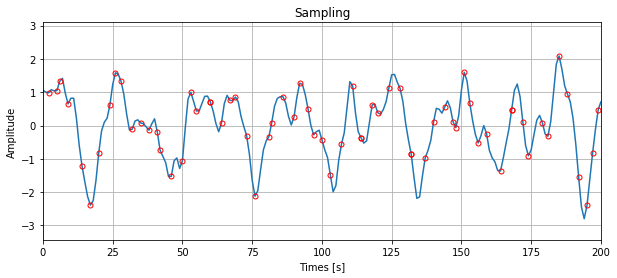

In [57]:
sf = SignalFrame()
s01 = sf.read_wave('../data/CETIM.wav', coeff_amplitude=1/10000,trunc=0.0125)
s01.sampler_uniform(rate=0.3)
signal_sampled_uni_r03 = s01.temporal_sampled
phi_uni_r03 = s01.phi

In [58]:
y = signal_sampled_uni_r03
N = len(s01.temporal)

In [59]:
## specify initial values
init = {"x": np.zeros(N),
        "tau": 1,
        "lambda": 1,
        "gamma": np.ones(N),
        "v": np.zeros(N),
        }

## specify hyper parameters
hypers = {"a_lambda": 1e-6,
         "b_lambda": 1e-6,
         "a_tau": 1e-6,
         "b_tau": 1e-6
         }

In [68]:
iters = 600
trace = gibbs(signal_sampled_uni_r03, iters, init, hypers,phi_uni_r03)

(9000,)
0: 3395.9829392460138 [1.87274433] [10.9737282]
1: 5229.852028924936 [1.51234734] [11.94915373]
2: 3558.5941304437133 [1.85638391] [15.33589973]
3: 3953.013747854649 [1.78453007] [19.98191513]
4: 3292.3533592180274 [1.88690285] [25.95137548]
5: 3271.613516723825 [1.82844307] [33.35601359]
6: 2880.042980886147 [1.91449503] [42.07418884]
7: 2756.569917457184 [1.91338441] [53.2418204]
8: 2573.0887275046657 [1.97046514] [65.04129195]
9: 2443.0836822128017 [1.95734328] [79.01867747]
10: 2281.846560844043 [2.02179673] [94.62125599]
11: 2225.305168102187 [2.0888396] [112.0542913]
12: 2095.141979724492 [2.13295218] [125.27686561]
13: 2049.314936651926 [1.9712305] [140.53245984]
14: 1925.6266966616158 [2.10327771] [165.62565641]
15: 1901.8938671778894 [1.98153405] [186.85712283]


KeyboardInterrupt: 

In [ ]:
trace.columns

In [ ]:
test = trace.loc[:,['lambda','tau']]

In [ ]:
test

In [ ]:
test['tau'] = test['tau'].apply(lambda x: np.asscalar(x))

In [ ]:
traceplot = test.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

In [ ]:
trace.to_csv('trace_10000.csv')

In [ ]:
F = open("lambda1.txt","r")
lambdas = [float(i) for i in F.read().splitlines()]

In [ ]:
sns.distplot(lambdas[0:50]).set_title('$\lambda$ : Itération 50')

In [ ]:
sns.distplot(lambdas[0:200]).set_title('$\lambda$ : Itération 200')

In [ ]:
sns.distplot(lambdas[0:600]).set_title('$\lambda$ : Itération 600')

In [ ]:
np.mean(lambdas[50:])